**Importing** **Libraries**


In [ ]:
import librosa
from librosa import display
import soundfile
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import Audio
import joblib
from joblib import dump, load
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_waveform(signal, sampling_rate ,emotion):
    # Get audio signal length in seconds
    duration = len(signal) / sampling_rate
    # Generate time axis for the audio signal
    time = np.arange(0, duration, 1/sampling_rate)
    # Create a figure and axis for the waveplot
    fig, ax = plt.subplots()
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    # Plot the audio signal as a waveplot
    ax.plot(time, signal, linewidth=0.5, color='black')
    ax.set_xlim([0, duration])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

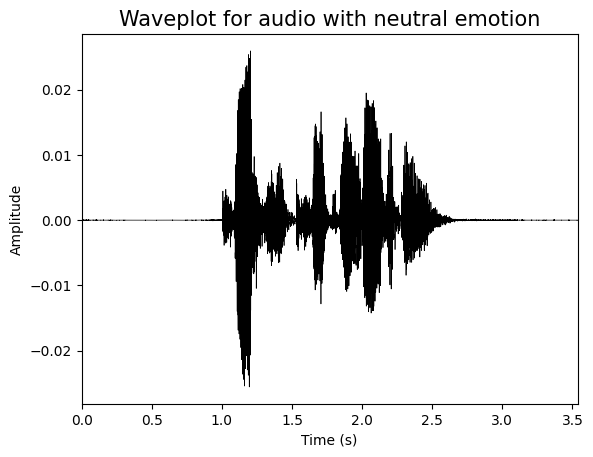

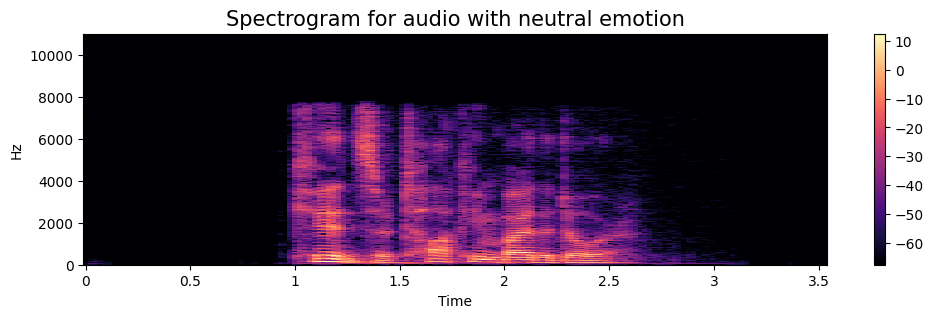

In [ ]:
emotion='neutral'
path = '/content/drive/MyDrive/New folder/Actor_01/03-01-02-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
plot_waveform(data, sampling_rate , emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

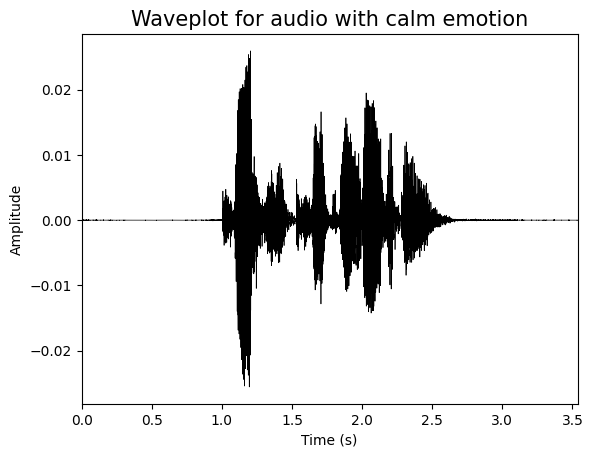

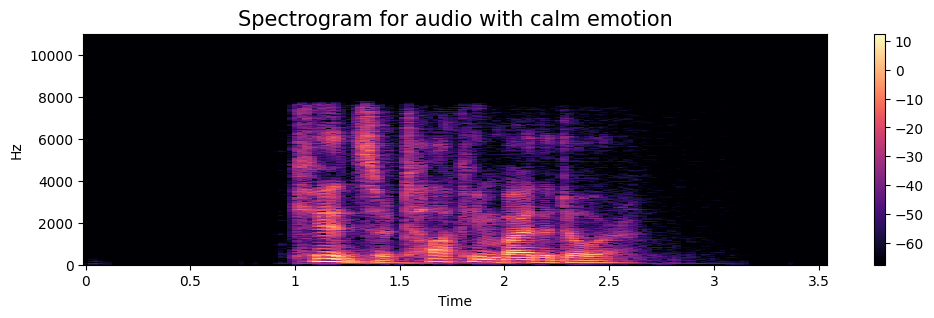

In [ ]:
emotion='calm'
path = '/content/drive/MyDrive/New folder/Actor_01/03-01-02-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
plot_waveform(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


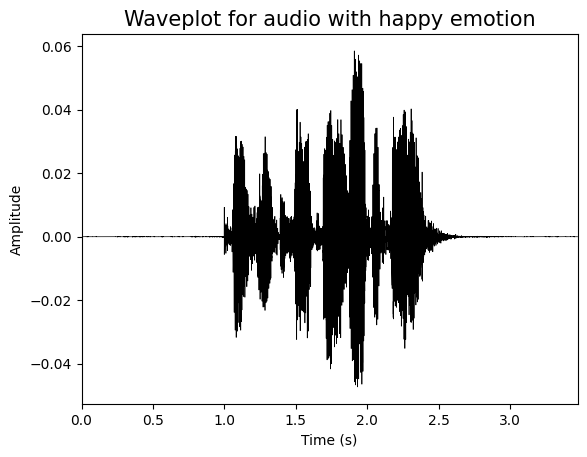

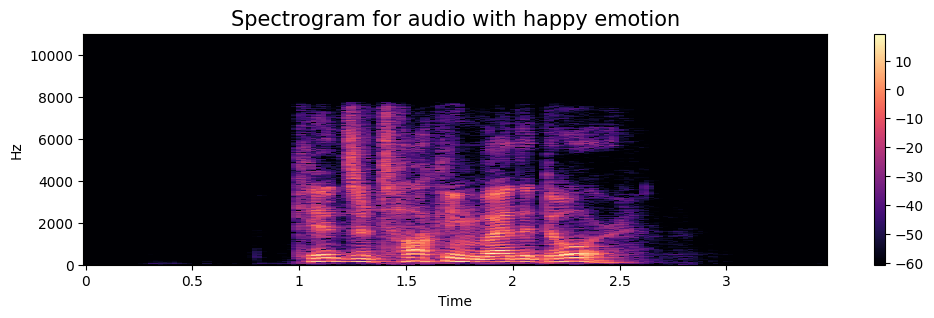

In [ ]:
emotion='happy'
path = '/content/drive/MyDrive/New folder/Actor_01/03-01-03-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
plot_waveform(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

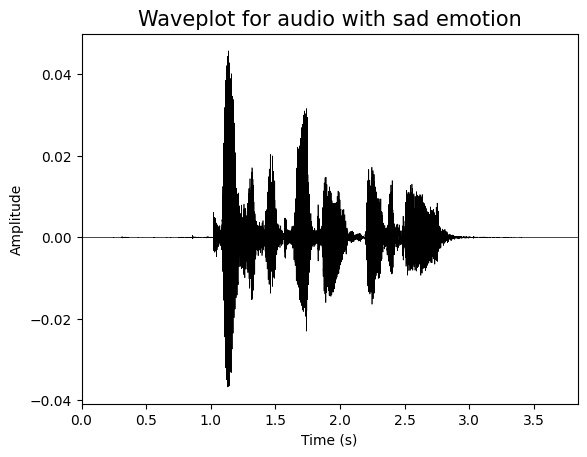

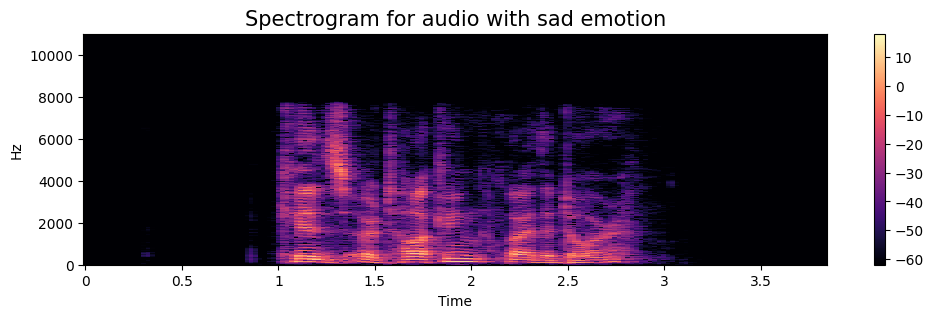

In [ ]:
emotion='sad'
path = '/content/drive/MyDrive/New folder/Actor_01/03-01-04-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
plot_waveform(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

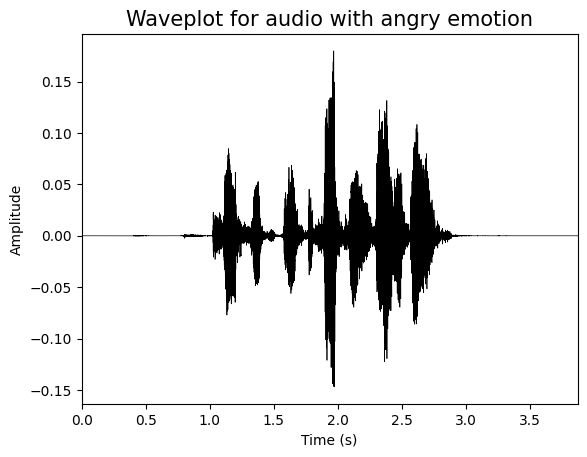

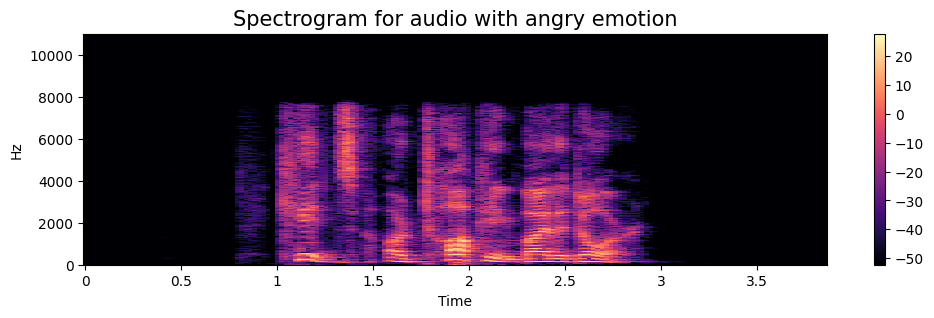

In [ ]:
emotion='angry'
path = '/content/drive/MyDrive/New folder/Actor_01/03-01-05-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
plot_waveform(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

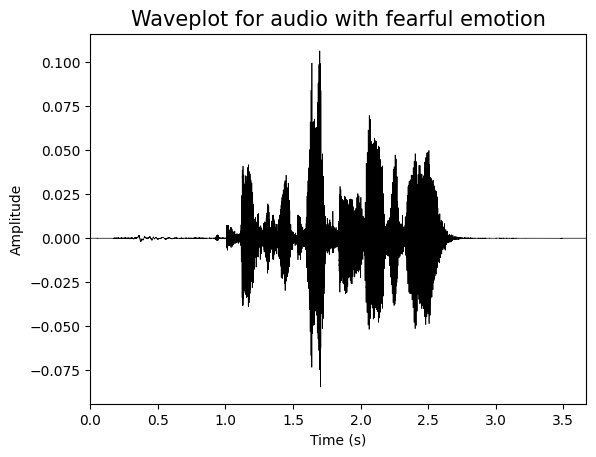

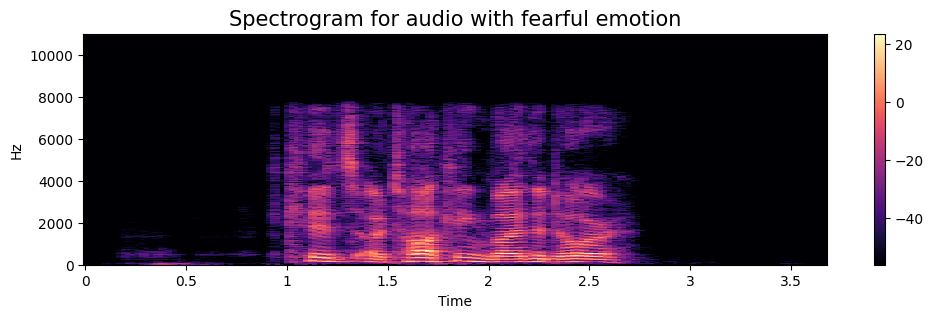

In [ ]:
emotion='fearful'
path = '/content/drive/MyDrive/New folder/Actor_01/03-01-06-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
plot_waveform(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

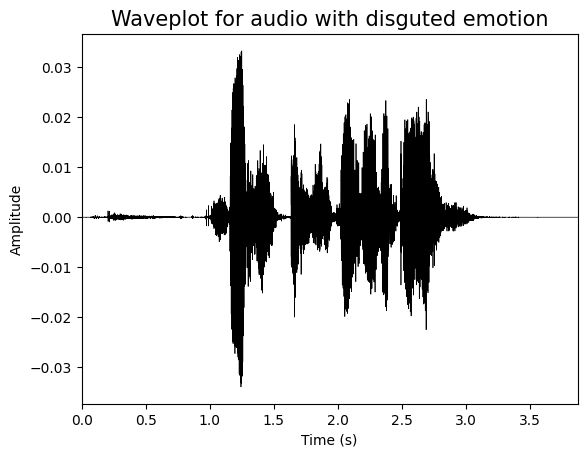

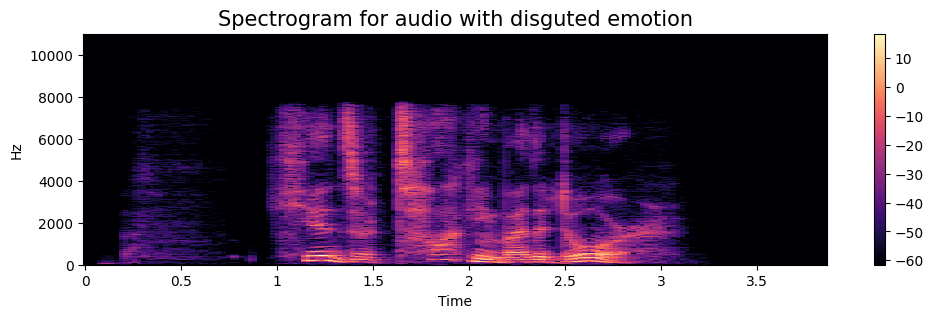

In [ ]:
emotion='disguted'
path = '/content/drive/MyDrive/New folder/Actor_01/03-01-07-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
plot_waveform(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

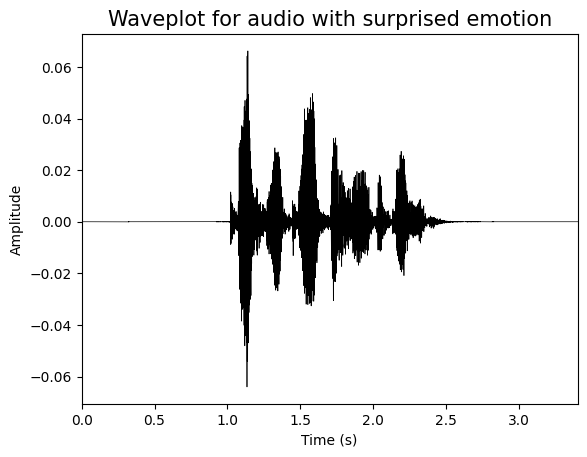

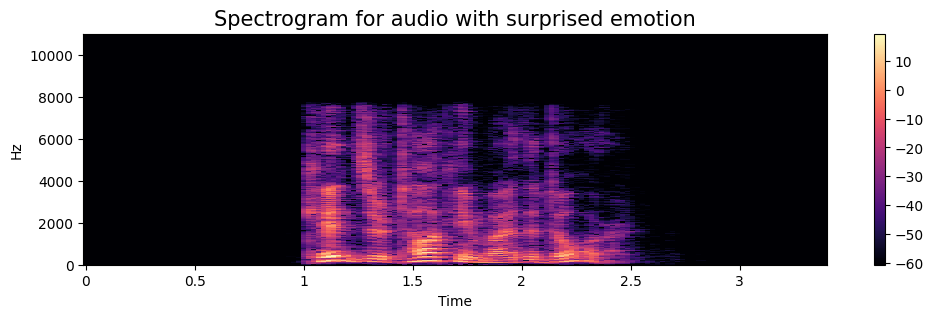

In [ ]:
emotion='surprised'
path = '/content/drive/MyDrive/New folder/Actor_01/03-01-08-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
plot_waveform(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

The above plot describes the change in amplitude (loudness) of a signal over time domain. The next challenge is extracting the significant features from this wave form that can easily help to distinguish emotions embedded.


There are numerous ways to extract features from a raw audio waveform using signal processing such as zero crossing rate, spectral centroid, zooming in, and so on. After some experiments, I have decided to move forward with a combination of three main acoustic features which will be discussed below at a high level. In the case of audio waves, the variations in the amplitudes and frequencies contained in it can provide insights. A single audio wave consists of multiple single frequency signals. Extracting these individual, single frequency signals from the audio is called spectrum analysis.


Let’s think about what happens when we hear an audio clip with different kinds of  background noise. Human brains are a kind of spectrum analyzer which automatically split up the frequency signals in the audio and help us focus more on the main component, ignoring the single frequency signals of background noise. This same feature of splitting up the single frequencies in an audio file can be obtained by a mathematical technique called Fourier Transform. It basically transforms a time-domain signal into a frequency-domain signal. We now have information on how amplitude and frequency vary with time (separately, not together).


Our next task is to get the frequency and amplitude variations together with time. This is where the Spectogram comes in handy — it is a snapshot of the information of frequency, time, and amplitude in one. We will be using Mel-frequency cepstral coefficients (MFCCs). We will create a numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file.

# Feature extraction and loading


In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def pitch(data, samplingrate, pitchfactor=0.7):
    return librosa.effects.pitch_shift(data, sr = samplingrate,n_steps =  pitchfactor)

In [ ]:
!pip install resampy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.0 MB/s eta 0:00:00


In [ ]:
!pip install soundfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import soundfile as sf

In [ ]:
path = '/content/drive/My Drive/New folder'
lst = []

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        y, sample_rate = sf.read(os.path.join(subdir, file))
        X = librosa.resample(y, orig_sr=sample_rate, target_sr=22050)


        
        file = int(file[6:8])
        # data without augmentation
        result = extract_features(X)
        arr = result, file
        lst.append(arr)

        # data after augmentation
        # noise
        noised_data = noise(X)
        res2 = extract_features(noised_data)
        arr = res2, file
        lst.append(arr)

        # stretch and pitch
        stretched_data = stretch(X)
        data_stretch_pitch = pitch(stretched_data, sample_rate)
        res3 = extract_features(data_stretch_pitch)
        arr = res3, file
        lst.append(arr)
      
      # If the file is not valid, skip it
      except ValueError:
        continue

In [ ]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [ ]:
X = np.asarray(X)
y = np.asarray(y)
X.shape, y.shape

((4320, 162), (4320,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


pipeline_dtree = Pipeline([('scalar1',StandardScaler()),
                           ('dtree_classifier',DecisionTreeClassifier())])

pipeline_rforest = Pipeline([('scalar2',StandardScaler()),
                           ('rforest_classifier',RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                                                        max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                                                        n_estimators= 22000, random_state= 5))])

pipeline_mlp = Pipeline([('scalar4',StandardScaler()),
                           ('mlp_classifier',MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, 
                                                           hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500))])

pipeline_lgbm = Pipeline([('scalar5',StandardScaler()),
                           ('lgbm_classifier',LGBMClassifier(learning_rate=0.05,
                                                              n_estimators=10000,
                                                              max_depth=5))])

In [ ]:
# list of all model pipelines
pipelines = [pipeline_dtree, pipeline_rforest, pipeline_mlp, pipeline_lgbm]

In [ ]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

In [ ]:
# dictionary of pipelines
pipe_dict = {0:"Decision Tree", 
             1:"Random Forest", 
             2:"Multi-layered Perceptron", 
             3:"Light GBM",}

In [ ]:
# fiting the pipelines
for pipe in pipelines:
  pipe.fit(X_train,y_train)

In [ ]:
results = pd.DataFrame(data=None, columns=['Model','Accuracy'])

In [ ]:
import pandas as pd

results = pd.DataFrame(columns=['Model', 'Accuracy'])

for i in range(len(pipelines)):
    model = pipelines[i]
    acc = round(model.score(X_test, y_test) * 100, 2)
    results = results.append({'Model': pipe_dict[i], 'Accuracy': acc}, ignore_index=True)

best_accuracy = results['Accuracy'].max()

best_models = results[results['Accuracy'] == best_accuracy]

if len(best_models) == 1:
    best_pipeline = pipelines[best_models.index[0]]
    best_classifier = best_models.iloc[0]['Model']
else:
    best_pipeline = pipelines[best_models.index[0]]
    best_classifiers = best_models['Model'].tolist()
    best_classifier = best_classifiers[0]

print(f"The best classifier is {best_classifier} with an accuracy of {best_accuracy}%")


<ipython-input-46-362eb12c4120>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': pipe_dict[i], 'Accuracy': acc}, ignore_index=True)
<ipython-input-46-362eb12c4120>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': pipe_dict[i], 'Accuracy': acc}, ignore_index=True)
<ipython-input-46-362eb12c4120>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': pipe_dict[i], 'Accuracy': acc}, ignore_index=True)


The best classifier is Light GBM with an accuracy of 76.31%


<ipython-input-46-362eb12c4120>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': pipe_dict[i], 'Accuracy': acc}, ignore_index=True)
